### Identify locations of prominent o2-temp anomaly patterns

Given pattern such as this...
![o2temp](../figures/ESM4_piControl_D/SouthernOcean/o2_in_thetao.anom.histogram.03*.png)

How to isolate specific lobes in that plot and locate them in geographical space?

In [1]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import matplotlib.pyplot as plt
import os
from dask.diagnostics import ProgressBar
from cmip_basins.basins import generate_basin_codes

In [2]:
config_id = 'ESM4_piControl_D'
domain = 'SouthernOcean'

ds = xr.Dataset()
if (config_id == 'ESM4_piControl_D') or (config_id == 'ESM4_historical_D1'):
    if config_id == 'ESM4_piControl_D':
        time = '03*'
    elif config_id == 'ESM4_historical_D1':
        time = '*'
        
    pathDict = {'pp':('/archive/oar.gfdl.cmip6/ESM4/DECK/'+config_id+'/'+
                        'gfdl.ncrc4-intel16-prod-openmp/pp'),
                'out':'ts',
                'local':'annual/5yr',
                'time':time}
    pathDict['ppname']='ocean_cobalt_omip_tracers_year_z_1x1deg'
    variables = ['o2','o2sat']
    for variable in variables:
        pathDict['add'] = variable
        path=gu.core.get_pathspp(**pathDict)
        # gu.core.issue_dmget(path)
        ds[variable] = gu.core.open_frompp(**pathDict)[variable]
    
    pathDict['ppname']='ocean_annual_z_1x1deg'
    variables = ['thetao','volcello']
    for variable in variables:
        pathDict['add'] = variable
        path=gu.core.get_pathspp(**pathDict)
        # gu.core.issue_dmget(path)
        ds[variable] = gu.core.open_frompp(**pathDict)[variable]
    gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
    # gu.core.issue_dmget(gridpath)
    grid = xr.open_dataset(gridpath)
    
ds = ds.squeeze()

In [3]:
codes = generate_basin_codes(grid.rename({'lon':'xh','lat':'yh'}), persian=True, style="gfdl")
grid['basin'] = codes.drop('lon').rename({'xh':'lon','yh':'lat'})

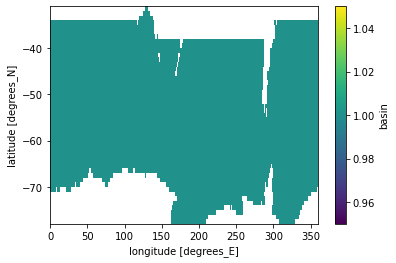

In [4]:
# Select domain
if domain == 'SouthernOcean':
    cond = grid['basin']==1
elif domain == 'NorthAtlantic':
    cond = (grid['basin']==2) & (grid['geolat']>0)
ds = ds.where(cond,drop=True)
grid = grid.where(cond,drop=True)
grid['basin'].plot()

In [5]:
# Calculate o2 and temp anomalies
if config_id == 'ESM4_piControl_D':
    ds_anom = ds-ds.mean('time')
elif config_id == 'ESM4_historical_D1':
    ds_anom = ds-ds.isel(time=slice(0,20)).mean('time')
# Replace volume with normal volume
ds_anom['volcello']=ds['volcello']

In [25]:
def calc_weightedstats_hs(hs,dim):
    array = hs[dim]*xr.ones_like(hs['volcello'])
    stats = xr.Dataset()
    stats['mean'] = array.weighted(hs['volcello'].fillna(0)).mean(dim)
    stats['std'] = array.weighted(hs['volcello'].fillna(0)).std(dim)
    return stats
    
def plot_hs_o2(ax,hs):
    hs = hs.squeeze()
    # stats
    stats = calc_weightedstats_hs(hs,'o2_bin')
    
    # plot
    im=ax.pcolormesh(hs['thetao_bin'],
                  hs['o2_bin'],
                  hs['volcello'].transpose(),
                  cmap='magma_r',
                  vmax=0.25)
    cb = plt.colorbar(im,ax=ax)
    ax.errorbar(stats['thetao_bin'],stats['mean'],yerr=stats['std'],
                linestyle='',
                marker='o',
                markerfacecolor='w',
                markeredgecolor='gray',
                ecolor='gray',
                alpha=0.5,
                label='Weighted-mean O2 in each temperature bin')
    ax.legend()
    ax.set_ylabel('OXYGEN [mol m-3]')
    ax.set_xlabel('TEMPERATURE [degC]')
    ax.grid(visible=True,which='major')
    cb.ax.set_ylabel('FRACTION \n(in each temperature bin)');
    
def plot_hs_o2_o2sat(ax,hs_o2,hs_o2sat):
    # First plot o2
    plot_hs_o2(ax,hs_o2)
    # Add oxygen saturation
    stats_o2s = calc_weightedstats_hs(hs_to2s,'o2sat_bin')
    ax.plot(stats_o2s['thetao_bin'],stats_o2s['mean'],
            linestyle=':',
            color='tab:green',
            marker='.',
            markerfacecolor='w',
            markeredgecolor='tab:green',
            label='Weighted-mean O2sat')
    ax.legend()

### Pick out specific o2&temp anomaly ranges and plot in space

In [17]:
# Bounds of anomaly of interest
o2anom = np.array([0.0025,0.005])
thetaoanom = np.array([-0.1,0])
# Get histogram but sum only in time and depth
hs_to2 = xr.Dataset()
hs_to2['volcello'] = histogram(ds_anom['thetao'],ds_anom['o2'],
                             bins=[thetaoanom,o2anom],
                             weights=ds_anom['volcello'],
                             dim=['z_l','time'])
hs_to2 = hs_to2.squeeze()
# normalize in each temperature bin
# hs_to2 = hs_to2/hs_to2.sum('o2_bin')

[########################################] | 100% Completed |  5.7s


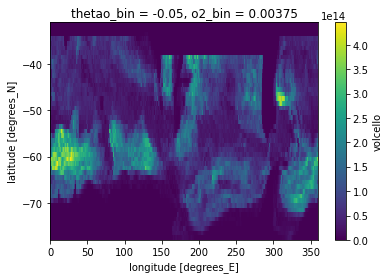

In [16]:
with ProgressBar():
    hs_to2['volcello'].plot()

### What about selecting along specific slopes?

In [50]:
thetao_bins = np.arange(-0.25,0.25,0.01)
o2_bins = np.arange(-0.01,0.01,0.0005)
hs_to2 = xr.Dataset()
hs_to2['volcello'] = histogram(ds_anom['thetao'],ds_anom['o2'],
                             bins=[thetao_bins,o2_bins],
                             weights=ds_anom['volcello'],
                             dim=['z_l','time'])
hs_to2 = hs_to2.squeeze()

In [51]:
with ProgressBar():
    hs_to2 = hs_to2.compute()

[########################################] | 100% Completed | 12.7s


In [91]:
m = 0.025
x = hs_to2['thetao_bin']
y = m*x

(-0.00975, 0.009250000000000017)

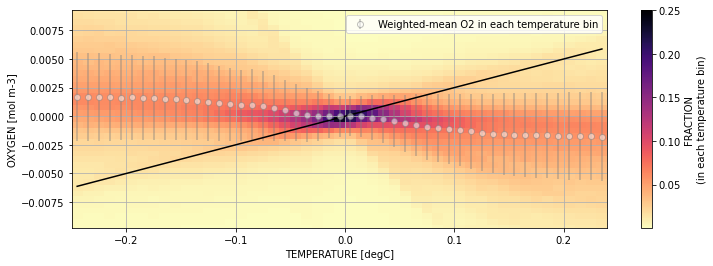

In [92]:
# Visualize
tmp = hs_to2.sum(['lat','lon'])
tmp = tmp/tmp.sum('o2_bin')
fig,ax = plt.subplots(figsize=(12,4))
plot_hs_o2(ax,tmp)
ax.plot(x,y,'k-')
ax.set_ylim([hs_to2['o2_bin'][0],hs_to2['o2_bin'][-1]])

In [93]:
nt = len(x)
da = xr.zeros_like(grid['geolon'])
for i in range(nt):
    if (y[i]<hs_to2['o2_bin'][0]) or (y[i]>hs_to2['o2_bin'][-1]):
        continue
    da += hs_to2['volcello'].sel(thetao_bin=x[i]).sel(o2_bin=y[i],method='nearest')

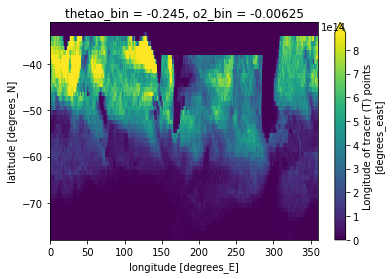

In [94]:
da.plot(robust=True)

In [95]:
m = -0.1
x = hs_to2['thetao_bin']
y = m*x

(-0.00975, 0.009250000000000017)

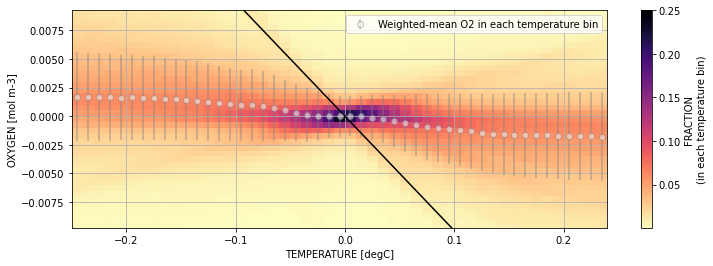

In [96]:
# Visualize
tmp = hs_to2.sum(['lat','lon'])
tmp = tmp/tmp.sum('o2_bin')
fig,ax = plt.subplots(figsize=(12,4))
plot_hs_o2(ax,tmp)
ax.plot(x,y,'k-')
ax.set_ylim([hs_to2['o2_bin'][0],hs_to2['o2_bin'][-1]])

In [97]:
nt = len(x)
da = xr.zeros_like(grid['geolon'])
for i in range(nt):
    if (y[i]<hs_to2['o2_bin'][0]) or (y[i]>hs_to2['o2_bin'][-1]):
        continue
    da += hs_to2['volcello'].sel(thetao_bin=x[i]).sel(o2_bin=y[i],method='nearest')

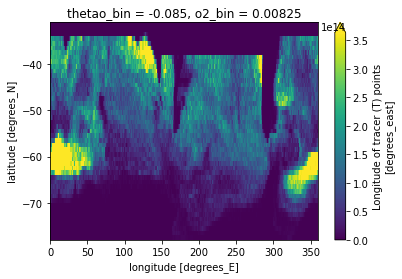

In [98]:
da.plot(robust=True)

In [103]:
m = -0.035
x = hs_to2['thetao_bin']
y = m*x

(-0.00975, 0.009250000000000017)

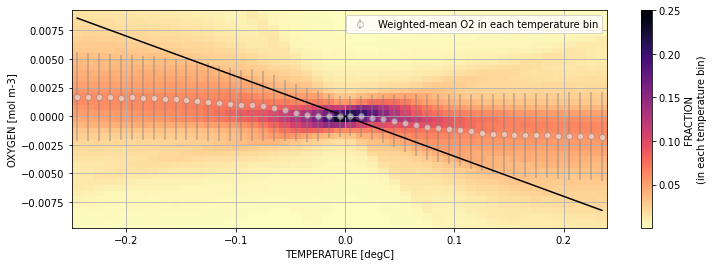

In [104]:
# Visualize
tmp = hs_to2.sum(['lat','lon'])
tmp = tmp/tmp.sum('o2_bin')
fig,ax = plt.subplots(figsize=(12,4))
plot_hs_o2(ax,tmp)
ax.plot(x,y,'k-')
ax.set_ylim([hs_to2['o2_bin'][0],hs_to2['o2_bin'][-1]])

In [105]:
nt = len(x)
da = xr.zeros_like(grid['geolon'])
for i in range(nt):
    if (y[i]<hs_to2['o2_bin'][0]) or (y[i]>hs_to2['o2_bin'][-1]):
        continue
    da += hs_to2['volcello'].sel(thetao_bin=x[i]).sel(o2_bin=y[i],method='nearest')

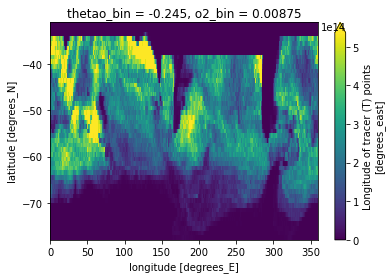

In [106]:
da.plot(robust=True)

In [109]:
m = -0.01
x = hs_to2['thetao_bin']
y = m*x

(-0.00975, 0.009250000000000017)

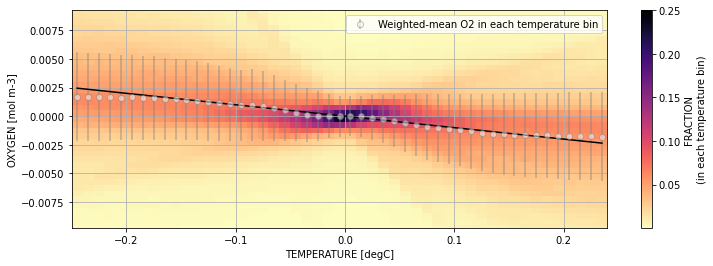

In [110]:
# Visualize
tmp = hs_to2.sum(['lat','lon'])
tmp = tmp/tmp.sum('o2_bin')
fig,ax = plt.subplots(figsize=(12,4))
plot_hs_o2(ax,tmp)
ax.plot(x,y,'k-')
ax.set_ylim([hs_to2['o2_bin'][0],hs_to2['o2_bin'][-1]])

In [111]:
nt = len(x)
da = xr.zeros_like(grid['geolon'])
for i in range(nt):
    if (y[i]<hs_to2['o2_bin'][0]) or (y[i]>hs_to2['o2_bin'][-1]):
        continue
    da += hs_to2['volcello'].sel(thetao_bin=x[i]).sel(o2_bin=y[i],method='nearest')

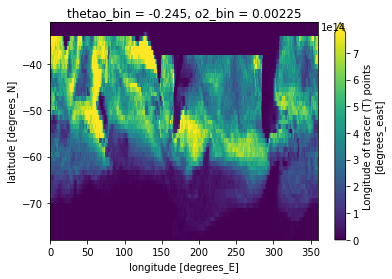

In [112]:
da.plot(robust=True)